# Klasifikasi Citra Mata Menggunakan Convolutional Neural Network
Dataset: Eye-dataset (https://www.kaggle.com/datasets/kayvanshah/eye-dataset)

## 1. Persiapan Environment dan Mengunduh Dataset

In [ ]:
!pip install kaggle tensorflow_datasets
!pip install --upgrade tensorflow keras tensorflowjs
!pip install -q tflite

In [ ]:
# Download and unzip the dataset
from google.colab import files
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Mengunduh dataset Eye Dataset dari Kaggle
!kaggle datasets download -d kayvanshah/eye-dataset

# Mengekstrak file ZIP
!unzip eye-dataset.zip -d /content/eye-dataset

In [2]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 2. Pemeriksaan Data
### a. Memeriksa isi kelas dalam dataset

In [3]:
dataset_dir = '/content/eye-dataset/Eye dataset'
class_names = os.listdir(dataset_dir)
print(f'Kelas dalam dataset: {class_names}')

Kelas dalam dataset: ['right_look', 'forward_look', 'left_look', 'close_look']


### b. Memeriksa jumlah data dalam dataset
Dilakukan untuk memenuhi saran dari reviewer bahwa jumlah data harus lebih dari 10.000 data.

In [ ]:
# Path dasar ke dataset
base_dir = '/content/eye-dataset/Eye dataset'

# Subfolder yang ada dalam dataset
classes = ['close_look', 'forward_look', 'left_look', 'right_look']

# Mengumpulkan semua path gambar dari semua kelas
image_paths = []
for cls in classes:
    cls_path = os.path.join(base_dir, cls, '*.png')
    image_paths.extend(glob.glob(cls_path))

print(f'Total gambar dalam dataset: {len(image_paths)}')

Total gambar dalam dataset: 11545


### c. Memeriksa ukuran resolusi citra dalam dataset
Dilakukan untuk memenuhi saran dari reviewer untuk menggunakan dataset dengan resolusi yang berbeda-beda

In [5]:
# Memastikan kita memiliki cukup gambar untuk dipilih
if len(image_paths) < 5:
    print("Jumlah gambar kurang dari 5. Silakan periksa kembali dataset Anda.")
else:
    # Memilih 5 gambar secara acak
    random_sample = random.sample(image_paths, 5)

    # Mencetak resolusi setiap gambar
    print("Resolusi dari 5 gambar acak:")
    for img_path in random_sample:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                print(f'{os.path.basename(img_path)}: {width} x {height}')
        except Exception as e:
            print(f'Error membuka {img_path}: {e}')

Resolusi dari 5 gambar acak:
eye_closed(2382).png: 118 x 118
forward_look (59).png: 111 x 111
forward_look (2115).png: 68 x 68
eye_closed(3562).png: 100 x 100
right_(633).png: 117 x 117


## 3. Pra-Pemrosesan Data
### a. Pembagian Data Training dan Data Testing
Data training dan data testing dibagi dengan proporsi 80%:20%

In [ ]:
# Membagi dataset menjadi train dan test set dengan direktori terpisah
# Kita akan membuat folder train dan test di dalam /content/eye-dataset
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Membuat direktori train dan test jika belum ada
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(test_dir, class_name))

        class_path = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_path)
        # Membagi gambar menjadi 80% train dan 20% test
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_name, img)
            os.symlink(src, dst)

        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_name, img)
            os.symlink(src, dst)

### b. Membuat Data Generator
Data generator digunakan untuk memuat data citra dalam batch ke dalam memori agar tidak membebani memori komputer.

In [7]:
# Membuat ImageDataGenerator untuk train dan test
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Menentukan ukuran target dan batch size
TARGET_SIZE = (224, 224)
batch_size = 32

# Membuat generator untuk train dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11486 images belonging to 4 classes.
Found 2874 images belonging to 4 classes.


**Melihat hasil dari data generator**

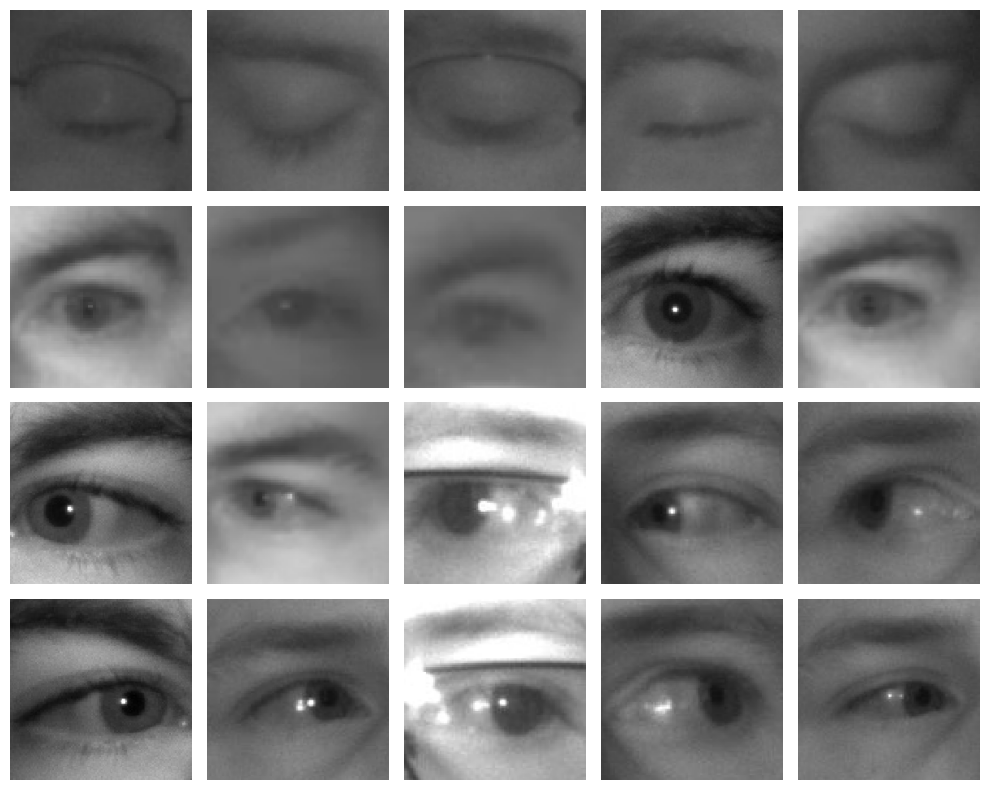

In [ ]:
# Menampilkan beberapa gambar dari train_generator
def plot_samples(generator, samples=5):
    """
    Menampilkan beberapa sampel gambar dari generator

    Args:
    generator: generator dari ImageDataGenerator
    samples: jumlah sampel yang akan ditampilkan di setiap kelas
    """
    plt.figure(figsize=(samples * 2, 2 * len(generator.class_indices)))
    class_names = list(generator.class_indices.keys())
    for i, class_name in enumerate(class_names):
        # Mendapatkan batch pertama
        x, y = next(generator)
        # Mendapatkan indeks kelas
        class_idx = generator.class_indices[class_name]
        # Menemukan gambar yang sesuai dengan kelas
        idxs = np.where(np.argmax(y, axis=1) == class_idx)[0]
        selected_idxs = np.random.choice(idxs, samples, replace=False)
        for j, idx in enumerate(selected_idxs):
            plt_idx = i * samples + j + 1
            plt.subplot(len(class_names), samples, plt_idx)
            plt.imshow(x[idx])
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_name, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_samples(train_generator, samples=5)

## 4. Membangun Model Convolutional Neural Network
### a. Membangun Model CNN
Model CNN yang dibangun terdiri dari 3 layer konvolusi dan 2 layer dense. Menggunakan MaxPooling2D dan Flatten untuk mengubah dimensi citra. Juga terdapat BatchNormalization untuk membantu model agar lebih stabil.

In [9]:
model = Sequential([
    Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    Conv2D(64, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Conv2D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Conv2D(256, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(4, activation='softmax', kernel_initializer='glorot_normal')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,176,004 (4.49 MB)

 Trainable params: 1,174,980 (4.48 MB)

 Non-trainable params: 1,024 (4.00 KB)

### b. Melakukan kompilasi model
Model CNN yang dibangun dikompilasi dengan optimizer Adam, loss function categorical crossentropy, dan metrik akurasi.

In [10]:
# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### c. Membuat Callback
Membuat callback untuk menghentikan training jika tidak ada peningkatan pada metrik yang dipantau `(val_accuracy)` selama 5 epoch berturut-turut, dan mengembalikan model dengan akurasi terbaik.

In [11]:
# Implementasi Callback
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

## 5. Melatih Model
Model dilatih dengan data training menggunakan data generator yang telah dibuat sebelumnya, dengan jumlah epoch sebanyak 50.

In [12]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - accuracy: 0.8443 - loss: 0.4753 - val_accuracy: 0.9342 - val_loss: 0.2192
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9623 - loss: 0.1320 - val_accuracy: 0.9732 - val_loss: 0.1057
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9762 - loss: 0.0778 - val_accuracy: 0.9102 - val_loss: 0.2528
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9755 - loss: 0.0866 - val_accuracy: 0.8156 - val_loss: 0.4765
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9820 - loss: 0.0612 - val_accuracy: 0.8337 - val_loss: 0.4483
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.9835 - loss: 0.0550 - val_accuracy: 0.9506 - val_loss: 0.1560
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9843 - loss: 0.0539 - val_accuracy: 0.9722 - val_loss: 0.0849


## 6. Evaluasi Model
### a. Melihat hasil training model
Hasil pelatihan menunjukkan bahwa model memiliki tingkat akurasi pada data training sebesar 98,49% dan pada data validasi sebesar 97,22%. Hal ini menunjukkan model telah memenuhi saran dari reviewer.

In [13]:
# Evaluasi model
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f'Akurasi Train: {train_acc*100:.2f}%, Akurasi Validation: {val_acc*100:.2f}%')

if train_acc >= 0.95 and val_acc >= 0.95:
    print("Kriteria akurasi terpenuhi.")
else:
    print("Kriteria akurasi belum terpenuhi. Jangan menyerah dan putus asa")

Akurasi Train: 98.49%, Akurasi Validation: 97.22%
Kriteria akurasi terpenuhi.


### b. Membuat Plot Akurasi dan Loss
Di sini dilakukan visualisasi dari akurasi dan loss pada data training dan data validasi.

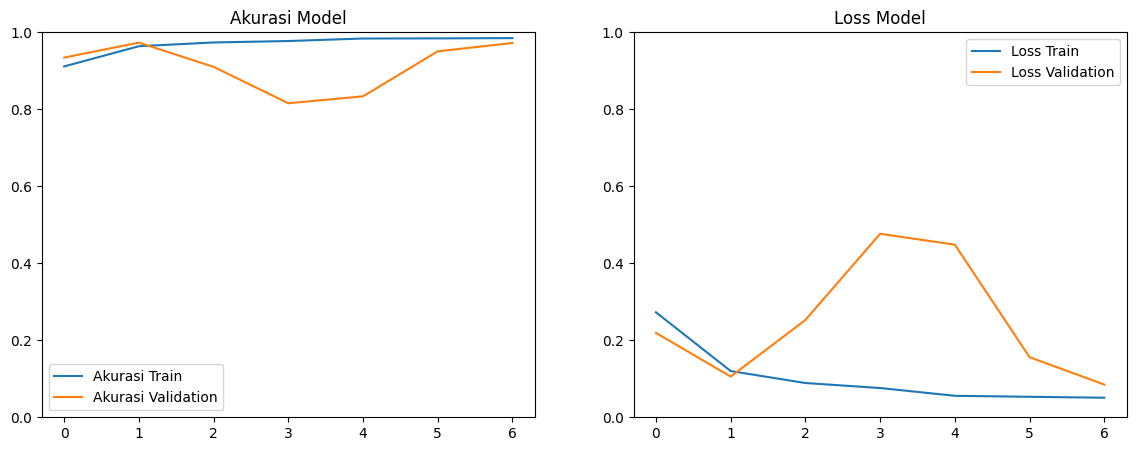

In [15]:
# Membuat plot akurasi dan loss
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Train')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.ylim(0,1)
plt.legend()
plt.title('Akurasi Model')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.ylim(0,1)
plt.legend()
plt.title('Loss Model')

plt.show()

## 7. Menyimpan Model
**Membuat direktori untuk menyimpan model**

In [17]:
# Membuat direktori utama dan subdirektori
os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

### a. Menyimpan model ke format SavedModel untuk TensorFlow Serving
Model disimpan dalam format SavedModel agar dapat digunakan untuk deployment dengan TensorFlow

In [19]:
# Menyimpan model dalam format SavedModel
model.export('submission/saved_model')
print("Model berhasil disimpan dalam format SavedModel.")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140135131506368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131498800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131552704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131551648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135133150752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131550416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131556400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131554288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131556752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140135131557456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14013513

### b. Menyimpan model ke format TF Lite
Model disimpan dalam format TF Lite agar dapat digunakan di perangkat mobile

In [20]:
# Mengonversi model ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Menyimpan model TF-Lite
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model berhasil dikonversi dan disimpan dalam format TF-Lite.")

# Menyimpan label ke dalam file label.txt
with open('submission/tflite/label.txt', 'w') as f:
    # Mengurutkan kelas berdasarkan indeks untuk memastikan urutan label yang benar
    sorted_classes = sorted(train_generator.class_indices.items(), key=lambda x: x[1])
    for class_name, index in sorted_classes:
        f.write(f"{class_name}\n")
print("Label berhasil disimpan dalam 'label.txt'.")

Model berhasil dikonversi dan disimpan dalam format TF-Lite.
Label berhasil disimpan dalam 'label.txt'.


### c. Menyimpan model ke format TensorFlow.js
Model disimpan dalam format TensorFlow.js agar dapat digunakan di web

In [21]:
# Mengonversi model ke format TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model submission/saved_model submission/tfjs_model
print("Model berhasil dikonversi dan disimpan dalam format TensorFlow.js.")

2024-11-02 15:00:31.621159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730559631.654955   12197 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730559631.665445   12197 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-02 15:00:35.704278: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1730559635.704469   12197 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

**Menyimpan file label kelas**

In [22]:
# Memuat label dari file label.txt
with open('submission/tflite/label.txt', 'r') as f:
    labels = f.read().splitlines()
print("Label kelas:", labels)

Label kelas: ['close_look', 'forward_look', 'left_look', 'right_look']


## 8. Melakukan Inference Model TF Lite
### a. Memuat model TF Lite

In [24]:
# Memuat model TF-Lite
interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()

# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Detail Input:", input_details)
print("Detail Output:", output_details)

Detail Input: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detail Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 33, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### b. Memuat dan memproses citra
Citra yang akan diuji diubah menjadi array numpy dan diubah ukurannya menjadi 224x224 pixel.

In [ ]:
def load_and_preprocess_image(image_path, target_size):
    """
    Memuat gambar dari path, mengubah ukuran, dan menormalisasi.

    Args:
    - image_path (str): Path ke gambar.
    - target_size (tuple): Ukuran target (height, width).

    Returns:
    - numpy array: Gambar yang telah diproses siap untuk inferensi.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

### c. Melakukan prediksi
Melakukan prediksi dari citra yang diuji dengan model TF Lite. Hasil inferensi menunjukkan bahwa model berhasil memprediksi citra yang diuji dengan benar.

In [30]:
# Path ke gambar uji
test_image_path = '/content/eye-dataset/Eye dataset/test/close_look/eye_closed (8).png'  # Contoh path

# Memuat dan memproses gambar
input_data = load_and_preprocess_image(test_image_path, TARGET_SIZE)

# Menetapkan tensor input
interpreter.set_tensor(input_details[0]['index'], input_data)

# Menjalankan inferensi
interpreter.invoke()

# Mendapatkan hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data, axis=1)[0]

print(f'Prediksi kelas: {labels[predicted_class]}')

Prediksi kelas: close_look


### d. Menampilkan beberapa citra dari semua kelas dan hasil prediksinya 

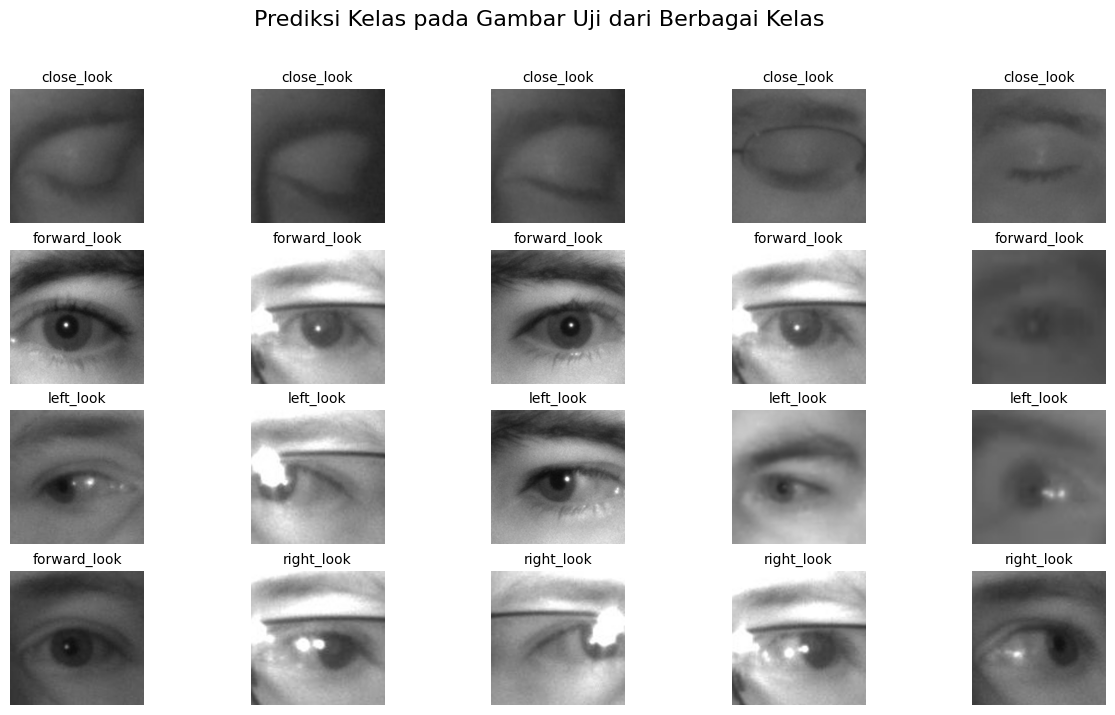

In [ ]:
# Variabel ini sebaiknya disesuaikan dengan direktori kelas pada dataset Anda
class_names = ["close_look", "forward_look", "left_look", "right_look"]
base_test_dir = "/content/eye-dataset/Eye dataset/test"
TARGET_SIZE = (224, 224)  # Sesuaikan jika Anda menggunakan ukuran berbeda

# Fungsi untuk memuat dan memproses gambar sesuai dengan ukuran model
def load_and_preprocess_image(img_path, target_size):
    """
    Memuat dan memproses gambar dari path.

    Args:
    - img_path (str): Path ke gambar.
    - target_size (tuple): Ukuran target (height, width).

    Returns:
    - numpy array: Gambar yang telah diproses siap untuk inferensi.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0  # Normalisasi
    return np.expand_dims(img, axis=0).astype(np.float32)

# Muat model TFLite untuk inferensi
interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Label kelas dari model yang disimpan di label.txt
with open("submission/tflite/label.txt", "r") as f:
    labels = f.read().splitlines()

# Menampilkan gambar dari setiap kelas dan hasil prediksinya
plt.figure(figsize=(15, 8))
for class_idx, class_name in enumerate(class_names):
    # Dapatkan direktori dan gambar untuk kelas ini
    test_class_dir = os.path.join(base_test_dir, class_name)
    test_images = os.listdir(test_class_dir)[:5]  # Ambil 5 gambar pertama

    for i, img_name in enumerate(test_images):
        img_path = os.path.join(test_class_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img_display = img.resize(TARGET_SIZE)

        # Menampilkan gambar
        plt_idx = class_idx * 5 + i + 1
        plt.subplot(4, 5, plt_idx)
        plt.imshow(img_display)
        plt.axis('off')

        # Melakukan inferensi
        input_data = load_and_preprocess_image(img_path, TARGET_SIZE)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output_data, axis=1)[0]

        # Menampilkan label prediksi
        plt.title(labels[predicted_class], fontsize=10)

plt.suptitle('Prediksi Kelas pada Gambar Uji dari Berbagai Kelas', fontsize=16)
plt.show()

## 9. Kesimpulan
Model CNN yang telah dibangun mampu mengklasifikasikan citra mata dengan baik dan telah disimpan dalam format yang berbeda-beda agar dapat digunakan di berbagai platform.